$\begin{align}
	&u_t + c(x)u_x = 0, \text{ em } [0,5] \times [0,6.4], \\
	&u(x,0) = f(x), \\~\\
	&c(x) = 1/5+\sin(x-1)^2, \\
	&f(x) = e^{-100(x-1)^2}
\end{align}$

In [31]:
using Pkg; Pkg.activate(".")

  Activating new project at `c:\Users\gozan\.vscode\Julia\SHOPDEPINN\Poster`


In [32]:
using JLD; D = load("Upwind_Dados.jld")["D"]; xt_D = D[1]; u_D = D[2];

In [33]:
using NeuralPDE, Lux, Random, Optimization, OptimizationOptimisers, ModelingToolkit, Zygote, Plots
import ModelingToolkit: Interval
import Optimization: OptimizationFunction, OptimizationProblem, solve
Random.seed!(0);

In [34]:
xmin = 0; xmax = 5; tmin = 0; tmax = 6.4
c(x) = 1/5+sin(x-1)^2
f(x) = exp(-100(x-1)^2)
aux(x,t) = ((t-2.0491*x) <= 1.4279) * ((t-2.0194*x) >= -4.9414)
u_exata(x,t) = exp(-100*(atan((1/sqrt(6))*tan(atan(sqrt(6)*tan(x-1))-(sqrt(6)/5)*t)))^2);

In [35]:
Neurons = 1
Layers = 1

N_D = length(u_D)
N_I = 1;

In [36]:
@parameters x t
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)

PDE = [Dt(u(x,t)) + c(x)*Dx(u(x,t)) ~ 0]
IC = [u(x, 0) ~ f(x)]

Ω = [x ∈ Interval(xmin, xmax), t ∈ Interval(tmin, tmax)];

In [37]:
Lux_NN = Chain(    
	Dense(2, Neurons, Lux.tanh; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform),

    [Dense(Neurons, Neurons, Lux.tanh; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform) for i in 1:1:Layers],

    Dense(Neurons, 1; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform))

Weight_NN = Lux.setup(Random.default_rng(0), Lux_NN)[1];

In [38]:
Strategy = FixedStochasticTraining(N_D, N_I) 

Discretization = PhysicsInformedNN(Lux_NN, Strategy, init_params = Weight_NN)

@named PDE_System = PDESystem(PDE, IC, Ω, [x, t], u(x, t))

Problem_NeuralPDE = symbolic_discretize(PDE_System, Discretization)

Weight_NN = Problem_NeuralPDE.flat_init_params

Strategy.sets[1] = xt_D'

pde_loss_functions = Problem_NeuralPDE.loss_functions.pde_loss_functions
bc_loss_functions = Problem_NeuralPDE.loss_functions.bc_loss_functions
Neural_Network(x,t,θ) = Problem_NeuralPDE.phi([x,t],θ)[1];

In [39]:
function loss_fit(θ, p)
    return sum(abs2, Neural_Network(xt_D[i,1],xt_D[i,2],θ) - u_D[i] for i = 1:length(u_D))/length(u_D) 
end
function callback_fit(p, l)
	if p.iter%1 == 0
		println("iteration: ", p.iter)
		println("loss_fit: ", l)
	end
	return false
end

OptimizationFunction_fit = OptimizationFunction(loss_fit, AutoZygote())
Epoch_fit = 3
OptimizationProblem_fit = OptimizationProblem(OptimizationFunction_fit, Weight_NN) 
result_fit = solve(OptimizationProblem_fit, ADAM(10^-3); callback = callback_fit, maxiters = Epoch_fit)
Weight_NN = result_fit.u;

iteration: 1
loss_fit: 0.8790918269115604
iteration: 2
loss_fit: 0.8743855612001812
iteration: 3
loss_fit: 0.8696963596822417
iteration: 3
loss_fit: 0.8696963596822417


In [40]:
function loss_fit_PINN(θ, α)
	fit = sum(abs2, Neural_Network(xt_D[i,1],xt_D[i,2],θ) - u_D[i] for i = 1:length(u_D))/length(u_D)
	PINN = sum(map(l -> l(θ), [pde_loss_functions; bc_loss_functions]))
    return α*fit + (1-α)*PINN
end
function callback_fit_PINN(P, l)
	if P.iter%1 == 0
		α = OptimizationProblem_fit_PINN.p
		println("iteration: ", P.iter)
		println("loss_fit_PINN: ", l)
		println("loss_fit: ", α*loss_fit(P.u, nothing))
		println("loss_PDE: ", (1-α)*map(l_ -> l_(P.u), pde_loss_functions)[1])
		println("loss_IC: ", (1-α)*map(l_ -> l_(P.u), bc_loss_functions)[1])
	end
	return false
end

OptimizationFunction_fit_PINN = OptimizationFunction(loss_fit_PINN, AutoZygote())
α = [0.8, 0.5, 0.3]
Epoch_fit_PINN = [2, 4, 3]
for i = 1:length(α)
    global OptimizationProblem_fit_PINN = OptimizationProblem(OptimizationFunction_fit_PINN, Weight_NN, α[i])
    result_fit_PINN = solve(OptimizationProblem_fit_PINN, ADAM(0.1); callback = callback_fit_PINN, maxiters = Epoch_fit_PINN[i])
    Weight_NN = result_fit_PINN.u
end

iteration: 1
loss_fit_PINN: 0.7896721805798612
loss_fit: 0.6957570877457934
loss_PDE: 1.6713031364036535e-5
loss_IC: 0.09389837980270384
iteration: 2
loss_fit_PINN: 0.420351527315671
loss_fit: 0.3849365454541494
loss_PDE: 1.1754055430270494e-5
loss_IC: 0.0354032278060913
iteration: 2
loss_fit_PINN: 0.420351527315671
loss_fit: 0.3849365454541494
loss_PDE: 1.1754055430270494e-5
loss_IC: 0.0354032278060913
iteration: 1
loss_fit_PINN: 0.32912279556264734
loss_fit: 0.24058534090884337
loss_PDE: 2.938513857567624e-5
loss_IC: 0.08850806951522827
iteration: 2
loss_fit_PINN: 0.10135103236247749
loss_fit: 0.0945015382267989
loss_PDE: 4.782930642443476e-5
loss_IC: 0.00680166482925415
iteration: 3
loss_fit_PINN: 0.052181759115488766
loss_fit: 0.029111854046547023
loss_PDE: 0.0011764000619131645
loss_IC: 0.02189350500702858
iteration: 4
loss_fit_PINN: 0.09884130151921257
loss_fit: 0.03841618404560116
loss_PDE: 0.0014389565694423246
loss_IC: 0.05898616090416908
iteration: 4
loss_fit_PINN: 0.05218175

In [41]:
function loss_PINN(θ, p)
    return sum(map(l -> l(θ), [pde_loss_functions; bc_loss_functions]))
end
function callback_PINN(p, l)
	if p.iter%1 == 0
		println("iteration: ", p.iter)
		println("loss_PINN: ", l)
		println("loss_PDE: ", map(l_ -> l_(p.u), pde_loss_functions)[1])
		println("loss_IC: ", map(l_ -> l_(p.u), bc_loss_functions)[1])
	end
	return false
end

OptimizationFunction_PINN = OptimizationFunction(loss_PINN, AutoZygote())
Epoch_PINN = 3
OptimizationProblem_PINN = OptimizationProblem(OptimizationFunction_PINN, Weight_NN) 
result_PINN = solve(OptimizationProblem_PINN, ADAM(10^-3); callback = callback_PINN, maxiters = Epoch_PINN)
Weight_NN = result_PINN.u;

iteration: 1
loss_PINN: 0.006002127337512993
loss_PDE: 0.00035716048931839334
loss_IC: 0.005644967
iteration: 2
loss_PINN: 0.005534349120342339
loss_PDE: 0.00035556230612954036
loss_IC: 0.005178787
iteration: 3
loss_PINN: 0.005086813495377758
loss_PDE: 0.0003540417187611845
loss_IC: 0.004732772
iteration: 3
loss_PINN: 0.005086813495377758
loss_PDE: 0.0003540417187611845
loss_IC: 0.004732772


In [42]:
PINN(x,t) = Neural_Network(x,t,Weight_NN);

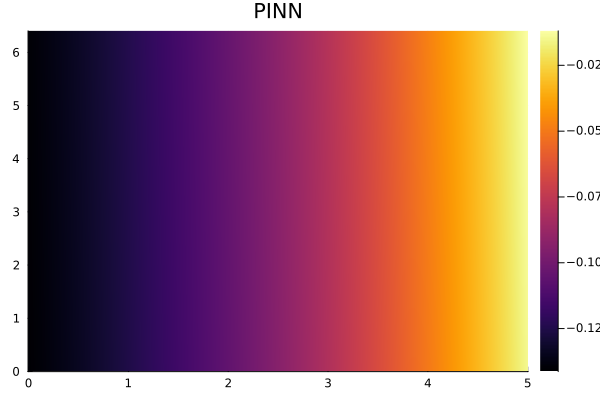

In [43]:
Δx = 0.01; x = xmin:Δx:xmax
Δt = Δx/1.2; t = tmin:Δt:tmax
u_PINN = [PINN(i, j) for j in t, i in x]
heatmap(x, t, u_PINN, title="PINN")